In [1]:
import pandas as pd
import ase
from ase import io
import numpy as np
import pandas as pd
import dionysus
import diode
from scipy.signal import argrelextrema
import math
from ase import Atoms
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.cluster import Birch
from sklearn.neighbors import KernelDensity


In [2]:
class glass_Atoms(Atoms):
    # def __init__(self):
    #    super().__init__()

    def get_dist(self):
        dim = np.diagonal(self.get_cell())
        positions = self.get_positions()
        x_dif = np.abs(positions[:, 0][np.newaxis, :] - positions[:, 0][:, np.newaxis])
        y_dif = np.abs(positions[:, 1][np.newaxis, :] - positions[:, 1][:, np.newaxis])
        z_dif = np.abs(positions[:, 2][np.newaxis, :] - positions[:, 2][:, np.newaxis])
        x_dif = np.where(x_dif > 0.5 * dim[0], np.abs(x_dif - dim[0]), x_dif)
        y_dif = np.where(y_dif > 0.5 * dim[1], np.abs(y_dif - dim[1]), y_dif)
        z_dif = np.where(z_dif > 0.5 * dim[2], np.abs(z_dif - dim[2]), z_dif)
        i_i = np.sqrt(x_dif**2 + y_dif**2 + z_dif**2)
        return i_i

    def set_new_chemical_symbols(self, dict):
        corr_symbols= [dict[i] for i in self.get_atomic_numbers()]
        atomic_numbers = self.set_chemical_symbols(corr_symbols)

    def get_pdf(self, target_atoms, rrange=10, nbin=100):
        if isinstance(target_atoms[0], str):
            types = self.get_chemical_symbols()
        if isinstance(target_atoms[0], int):
            types = self.get_atomic_numbers()
        types = np.array(types)
        distances = self.get_dist()
        atom_1 = np.where(types == target_atoms[0])[0]
        atom_2 = np.where(types == target_atoms[1])[0]
        dist_list = distances[np.ix_(atom_1, atom_2)]
        edges = np.linspace(0, rrange, nbin + 1)
        xval = edges[1:] - 0.5 * (rrange / nbin)
        volbin = []
        for i in range(nbin):
            vol = ((4 / 3) * np.pi * (edges[i + 1]) ** 3) - (
                (4 / 3) * np.pi * (edges[i]) ** 3
            )
            volbin.append(vol)

        h, bin_edges = np.histogram(dist_list, bins=nbin, range=(0, rrange))
        h[0] = 0
        pdf = (h / volbin) / (
            dist_list.shape[0] * dist_list.shape[1] / self.get_volume()
        )
        return xval, pdf

    def get_persistence_diagram(self, dimension=1, weights=None):
        coord = self.get_positions()
        data = np.column_stack([self.get_chemical_symbols(), coord])
        dfpoints = pd.DataFrame(data, columns=["Atom", "x", "y", "z"])
        chem_species = np.unique(self.get_chemical_symbols())

        if weights is None:
            radii = [0 for i in chem_species]
        elif isinstance(weights, dict):
            radii = [weights[i] for i in chem_species]
        elif isinstance(weights, list):
            radii = weights

        conditions = [(dfpoints["Atom"] == i) for i in chem_species]
        choice_weight = [i**2 for i in radii]

        dfpoints["w"] = np.select(conditions, choice_weight)
        dfpoints["x"] = pd.to_numeric(dfpoints["x"])
        dfpoints["y"] = pd.to_numeric(dfpoints["y"])
        dfpoints["z"] = pd.to_numeric(dfpoints["z"])

        points = dfpoints[["x", "y", "z", "w"]].to_numpy()
        simplices = diode.fill_weighted_alpha_shapes(points)
        f = dionysus.Filtration(simplices)
        m = dionysus.homology_persistence(f)
        dgms = dionysus.init_diagrams(m, f)

        # Gather the PD of loop in a dataframe
        dfPD = pd.DataFrame(
            data={
                "Birth": [p.birth for p in dgms[dimension]],
                "Death": [p.death for p in dgms[dimension]],
            }
        )
        return dfPD

    def get_local_persistence(self, center_id, cutoff):
        persistence_diagrams = []
        if isinstance(center_id, str):
            types = self.get_chemical_symbols()
        if isinstance(center_id, int):
            types = self.get_atomic_numbers()
        centers = np.where(types == center_id)[0]
        for i in centers:
            neighbors = np.where(self.get_dist()[i, :] < cutoff)[0]
            neighborhood = self[neighbors]
            neighborhood.center()
            persistence_diagrams.append(neighborhood.get_persistence_diagram())
        return persistence_diagrams

    def get_angular_dist(self, center_type, neigh_type, cutoff="Auto"):
        distances = self.get_dist()

        types = self.get_chemical_symbols()
        center_index = np.where(types == center_type)[0]
        neigh_index = np.where(types == neigh_type)[0]

        if cutoff == "Auto":
            pdf = self.get_pdf(target_atoms=[center_type, neigh_type])
            cutoff = pdf[0][self.find_min_after_peak(pdf[1])]
        elif isinstance(cutoff, float | int):
            cutoff = cutoff

        angles = []

        for center in center_index:
            neighbors = np.where(
                (distances[neigh_index, center] < cutoff)
                & (distances[neigh_index, center] > 0)
            )[0]
            if neighbors.shape[0] < 2:
                continue
            upper_index = np.triu_indices(neighbors.shape[0], k=1)
            comb_1 = np.meshgrid(neighbors, neighbors)[0][upper_index]
            comb_2 = np.meshgrid(neighbors, neighbors)[1][upper_index]
            indicies = np.vstack(
                (neigh_index[comb_1], np.full(len(comb_1), center), neigh_index[comb_2])
            ).T
            angles.append(self.get_angles(indicies, mic=True))
        return angles

    def get_coordination_number(self, center_type, neigh_type, cutoff="Auto"):
        distances = self.get_dist()
        types = self.get_chemical_symbols()
        atom_1 = np.where(types == center_type)[0]
        atom_2 = np.where(types == neigh_type)[0]
        dist_list = distances[np.ix_(atom_1, atom_2)]

        if cutoff == "Auto":
            pdf = self.get_pdf(target_atoms=[center_type, neigh_type])
            cutoff = pdf[0][self.find_min_after_peak(pdf[1])]
        elif isinstance(cutoff, float | int):
            cutoff = cutoff
        print(cutoff)
        coordination_numbers = []
        for center in range(len(atom_1)):
            neighbors = np.where(
                (dist_list[center, :] < cutoff) & (dist_list[center, :] > 0)
            )[0]
            coordination_numbers.append(neighbors.shape[0])
        return coordination_numbers

    def find_min_after_peak(self, padf):
        mins = argrelextrema(padf, np.less_equal, order=4)[0]
        second_min = [i for ind, i in enumerate(mins) if i != ind][0]
        return second_min

    def NBO_analysis(distances, center_index, neigh_index_1, neigh_index_2, cutoffs):
        P_neigh_unique = []
        for center in center_index:
            neighbors = np.where(
                (distances[neigh_index, center] < cutoff[0])
                & (distances[neigh_index, center] > 0)
            )[0]
            P_neigh_unique.append([O_ind[neigh] for neigh in neighbors])
        P_neigh_unique = np.unique(np.hstack(P_neigh_unique))

        bond_order = [0, 0, 0, 0]
        for neigh in P_neigh_unique:
            neighbor_list_1 = np.where(
                (distances[neigh_index_1, neigh] < cutoff[0])
                & (distances[neigh_index_1, neigh] > 0)
            )[0]
            neighbor_list_2 = np.where(
                (distances[neigh_index_2, neigh] < cutoff[1])
                & (distances[neigh_index_2, neigh] > 0)
            )[0]

            if neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 1:
                bond_order[0] += 1
            elif neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 2:
                bond_order[1] += 1
            elif neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 3:
                bond_order[2] += 1
            elif neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 0:
                bond_order[3] += 1
        return coordination_number

    def get_total_rdf(self, nbin=100, rrange=10):
        scattering_lengths = pd.read_csv("scattering_lengths.csv", sep=";", decimal=",")
        chemical_symbols = self.get_chemical_symbols()
        species = np.unique(chemical_symbols)
        b = np.array(
            [
                scattering_lengths[scattering_lengths["Isotope"] == i]["b"]
                for i in species
            ]
        ).flatten()
        c = [chemical_symbols.count(i) / len(chemical_symbols) for i in species]
        cb = [i * j for i, j in zip(c, b)]
        timesby = []
        for pair in itertools.product(cb, repeat=2):
            timesby.append(pair[0] * pair[1])
        dividetot = sum(timesby)
        cb_sum = (sum([i * j for i, j in zip(c, b)]) ** 2) / 100

        gr_tot = np.zeros([nbin])
        for ind, pair in enumerate(itertools.product(species, repeat=2)):
            pdf = self.get_pdf(
                target_atoms=[pair[0], pair[1]], rrange=rrange, nbin=nbin
            )
            gr_tot = gr_tot + (timesby[ind] * pdf[1]) / dividetot
        return pdf[0], gr_tot

    def get_partial_structure_factor(
        self, target_atoms, qrange=30, nbin=100, rrange=10
    ):
        chemical_symbols = self.get_chemical_symbols()
        species = np.unique(chemical_symbols)
        aveden = np.mean(
            [chemical_symbols.count(i) / self.get_volume() for i in species]
        )
        qval = np.linspace(0.5, qrange, nbin)
        xval, pdf = self.get_pdf(target_atoms=target_atoms, rrange=rrange, nbin=nbin)
        q_r = np.outer(qval, xval).T
        q_r = np.sin(q_r) / q_r
        A_q = (
            4 * math.pi * xval**2 * (pdf - 1) * q_r
        )  # *(np.sin(math.pi*xval/rrange)/(math.pi*xval/rrange))
        A_q = 1 + aveden * np.trapz(A_q, xval)
        return qval, A_q

    def get_strucutre_factor(self, nbin=100):
        scattering_lengths = pd.read_csv("scattering_lengths.csv", sep=";", decimal=",")
        chemical_symbols = self.get_chemical_symbols()
        species = np.unique(chemical_symbols)
        b = np.array(
            [
                scattering_lengths[scattering_lengths["Isotope"] == i]["b"]
                for i in species
            ]
        ).flatten()
        c = [chemical_symbols.count(i) / len(chemical_symbols) for i in species]
        cb = [i * j for i, j in zip(c, b)]
        timesby = []
        for pair in itertools.product(cb, repeat=2):
            timesby.append(pair[0] * pair[1])
        dividetot = sum(timesby)
        cb_sum = (sum([i * j for i, j in zip(c, b)]) ** 2) / 100

        S_q_tot = np.zeros(nbin)
        for ind, pair in enumerate(itertools.product(species, repeat=2)):
            qval, partial_sq = self.get_partial_structure_factor(
                target_atoms=[pair[0], pair[1]], nbin=nbin
            )
            S_q_tot = S_q_tot + (timesby[ind] * partial_sq) / dividetot
        return qval, S_q_tot

In [3]:
class LocalPD:
    def __init__(self, glass_atoms_list, center_atom, cutoff, dimension=1, weights=None, birch_threshold=0.075):
        self.atom_list = glass_atoms_list
        self.center_atom = center_atom
        self.cutoff = cutoff
        self.dimension = dimension
        self.weights = weights
        self.birch_threshold = birch_threshold

    def compute_features(self):
        sampling_centers = self.find_sampling_centers()
        features = []
        for atoms in self.atom_list:
            peristence_diagrams = self.get_local_persistence(atoms, self.center_atom, self.cutoff)
            features.append(self.kde_pd(sampling_centers, peristence_diagrams))
        return np.vstack(features)

    def center_atoms(self, atoms, center_atom):
        dim = np.diagonal(atoms.get_cell())
        positions = atoms.get_positions()
        x_dif = positions[:, 0] -  positions[center_atom,0]
        y_dif = positions[:, 1] -  positions[center_atom,1]
        z_dif = positions[:, 2] -  positions[center_atom,2]
        x_dif = np.where(x_dif > 0.5 * dim[0], positions[:, 0] - positions[center_atom, 0] - dim[0], x_dif)
        y_dif = np.where(y_dif > 0.5 * dim[1], positions[:, 1] - positions[center_atom, 1] - dim[1], y_dif)
        z_dif = np.where(z_dif > 0.5 * dim[2], positions[:, 2] - positions[center_atom, 2] - dim[2], z_dif)
        x_dif = np.where(x_dif < -0.5 * dim[0], positions[:, 0] - positions[center_atom, 0] + dim[0], x_dif)
        y_dif = np.where(y_dif < -0.5 * dim[1], positions[:, 1] - positions[center_atom, 1] + dim[1], y_dif)
        z_dif = np.where(z_dif < -0.5 * dim[2], positions[:, 2] - positions[center_atom, 2] + dim[2], z_dif)
        new_postions = np.vstack([x_dif,y_dif,z_dif]).T
        return new_postions

    def get_local_persistence(self, atom, center_id, cutoff):
        persistence_diagrams = []
        if isinstance(center_id, str):
            types = atom.get_chemical_symbols()
        if isinstance(center_id, int):
            types = atom.get_atomic_numbers()
        centers = np.where(np.array(types) == center_id)[0]
        for i in tqdm(centers):
            neighbors = np.where(atom.get_dist()[i, :] < cutoff)[0]
            neighborhood = atom[neighbors]
            center_index = np.where(neighbors == i)
            neighborhood.set_positions(self.center_atoms(neighborhood,center_index))
            persistence_diagrams.append(neighborhood.get_persistence_diagram(dimension=self.dimension, weights=self.weights))
        return persistence_diagrams

    def find_sampling_centers(self):
        peristence_diagrams = self.get_local_persistence(self.atom_list[0], self.center_atom, self.cutoff)
        total_df = pd.concat(peristence_diagrams)
        birth_death = np.array([total_df['Birth'], total_df['Death'] - total_df['Birth']]).T
        birch = Birch(n_clusters=100, threshold = self.birch_threshold).fit(birth_death)
        return birch.subcluster_centers_

    def kde_pd(self, centers, list_pds):
        features = []
        for pd in list_pds:
            data = np.vstack((pd['Birth'], pd['Death'] - pd['Birth'])).T
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data)
            features.append(np.exp(kde.score_samples(centers)))
        features = np.array(features)
        return features

In [4]:
atoms = io.read(f"/Users/rasmus/Library/CloudStorage/OneDrive-AalborgUniversitet/Ph.D. Projekt/sodium_silicate/30Na_800/data/114/propensity/27/md.lammpstrj", index=':' , format="lammps-dump-text")
atoms = [glass_Atoms(atom) for atom in atoms]

corr_atoms_dic = {1: 'Na', 2: 'O', 3:'Si'}
for atom in atoms:
    atom.set_new_chemical_symbols(corr_atoms_dic) 
atoms

KeyboardInterrupt: 

In [ ]:
atoms_all = []

for i in range(1,10,1):
    obj = pd.read_pickle(f'/Volumes/My Passport for Mac/sodium silicate/dataset_800/30Na_{i}.pickle')
    particle_type = obj["types"]
    type_dic = obj["type_dic"]
    symbols = list((pd.Series(particle_type.tolist())).map(type_dic))
    pos = obj["start_positions"]
    cell = obj["box"]
    atoms = glass_Atoms(f'Si3000', positions=pos, cell=cell, pbc=True)
    atoms.set_chemical_symbols(symbols)
    atoms_all.append(atoms)

LPD_features = LocalPD(atoms_all, 'Na', 5).compute_features()

100%|██████████| 600/600 [01:56<00:00,  5.13it/s]


In [ ]:
y = [] 

for i in range(1,10,1):
    obj = pd.read_pickle(f'/Volumes/My Passport for Mac/sodium silicate/dataset_800/30Na_{i}.pickle')
    particle_type = obj["types"]
    type_dic = obj["type_dic"]
    symbols = list((pd.Series(particle_type.tolist())).map(type_dic))
    Na_ind = np.where(np.array(symbols).flatten()=="Na")[0]
    pos = obj["start_positions"]
    trajectory_target_positions = obj["target_positions"]
    targets = np.mean([np.linalg.norm(t - pos, axis=-1) for t in trajectory_target_positions], axis=1)
    targets = targets[:,Na_ind]   
    y.append(targets)

y = np.array(y)
ys = np.swapaxes(y,1,2)
y_all = np.reshape(ys,(ys.shape[0]*ys.shape[1],ys.shape[2]))

In [ ]:
def PearsonCC2(output, target):
    x = output
    y = target
    vx = x - np.mean(x)
    vy = y - np.mean(y)
    cost = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    return cost

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
m = GradientBoostingRegressor(random_state=0)
m = LinearRegression()

loss = []
pearson = []
for t in range(0,9,1):
    x_train, x_test, y_train, y_test = train_test_split(LPD_features, y_all[:,t], test_size=0.20, random_state=42)
    regr = m
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    MSE = mean_squared_error(y_test,y_pred)
    Pearson_i = PearsonCC2(y_pred, y_test)
    loss.append(MSE)
    pearson.append(Pearson_i)
    print(f"Test error: {MSE}")
    print(f"Pearson: {Pearson_i}")

Test error: 6.079265529158714e-05
Pearson: 0.006473289019010621
Test error: 0.03109773664132023
Pearson: 0.12037554682142282
Test error: 0.10397700758881764
Pearson: 0.1489993123616825
Test error: 0.38611189486922376
Pearson: 0.20536715779676742
Test error: 1.1717835995580177
Pearson: 0.2990706221325103
Test error: 1.9848251604037812
Pearson: 0.31523415460844956
Test error: 5.25117424227259
Pearson: 0.3378245598243348
Test error: 7.488413211068977
Pearson: 0.34620277357278684


IndexError: index 8 is out of bounds for axis 1 with size 8

In [81]:
from ase.data import covalent_radii, atomic_numbers
import numpy as np
from pymatgen.core import Composition




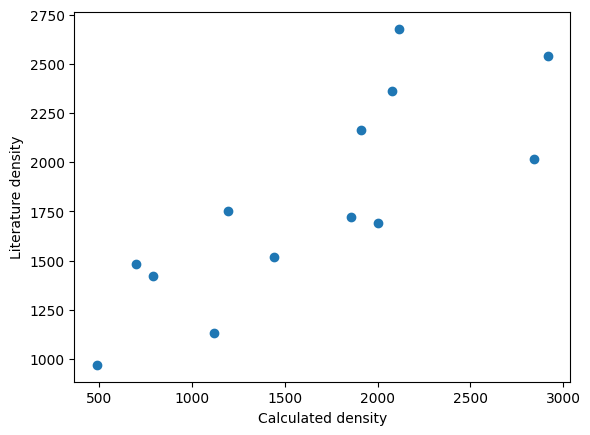

/var/folders/4j/7b2qbcqs4wz_drw27_tpwxvm0000gn/T/ipykernel_92318/2092440875.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(calc_volume, true_volume)


array([1.])

In [126]:
compositions = {"SiO": {"composition": "SiO2", "density": 2.2, "source": "", "sq_file": "106.csv", "sq_type": "neutron", "offset": 0, "formula": "SiO2"},
               "BO": {"composition": "B2O3", "density": 1.806, "source": "https://doi.org/10.1016/j.jnoncrysol.2009.12.013", "sq_file": "194.csv", "sq_type": "neutron", "offset": 1, "formula": "B2O3"},
               "PO": {"composition": "P2O5", "density": 2.385, "source": "https://doi.org/10.1016/S0022-3093(98)00529-8", "sq_file": "140.csv", "sq_type": "neutron", "offset": 0, "formula": "P2O5"},
               #"GeO": {"composition": "GeO2", "density": 1.806, "source": ""},
               "LiPS": {"composition": "Li7P3S11", "density": 1.938, "source": "https://doi.org/10.1038/srep21302", "sq_file": "1003_LiPS.csv", "sq_type": "xray", "offset": -1, "formula": "70Li2S-30P2S5"},
               "CaAlSiO": {"composition": "CaSiAl2O6", "density": 2.789, "source": "https://doi.org/10.1016/j.jnoncrysol.2016.05.018", "sq_file": "375_Ca33.33_RT.csv", "sq_type": "neutron", "offset": -2.25, "formula": "33CaO-33Al2O3-33SiO2"},
               "NaBO": {"composition": "NaB3O5", "density": 2.249, "source": "https://doi.org/10.1016/j.jnoncrysol.2009.12.013", "sq_file": "193.csv", "sq_type": "neutron", "offset": 1, "formula": "25Na2O-75B2O3"},
               "NaSiO": {"composition": "Na60Si70O170", "density": 2.466, "source": "https://doi.org/10.1088/0953-8984/19/33/335209", "sq_file": "458.csv", "sq_type": "neutron", "offset": -1, "formula": "30Na2O-70Si2O"},
               "NaPO": {"composition": "Na40P160O420", "density": 2.385, "source": "https://doi.org/10.1016/S0022-3093(98)00529-8", "sq_file": "142.csv", "sq_type": "neutron", "offset": 0, "formula": "20Na2O-80P2O5"},
               #"LiSiS": {"composition": "LiSiS", "density": 1.806, "source": ""},
               "LiBPO": {"composition": "Li76B62P62O286", "density": 2.460, "source": "https://doi.org/10.1016/j.jpowsour.2022.232302", "sq_file": "1004_LiBPO.csv", "sq_type": "xray", "offset": 0, "formula": "38Li2O-31B2O3-31P2O5"},
               #"LiAlGePO": {"composition": "LiAlGeP", "density": 1.80, "source": ""},
               #"KGePO": {"composition": "KGeP", "density": 1.806, "source": "https://www.sciencedirect.com/science/article/pii/S0022309308001415"},
               "NaSiS": {"composition": "Na100S150Si50", "density": 2.01, "source": "https://doi.org/10.1021/acs.jpcb.8b04353", "sq_file": "1001_NaSiS.csv", "sq_type": "xray", "offset": 0,  "formula": "Na2SiS3"},
               #"NaSiON": {"composition": "Na40Si80O156N16", "density": 2.49, "source": "https://doi.org/10.1111/j.1151-2916.1993.tb03652.x", "sq_file": "1002_NaSiON.csv", "sq_type": "neutron", "offset": -1},
               "LiGeS": {"composition": "Li2GeS3", "density": 2.436, "source": "https://doi.org/10.1016/j.jnoncrysol.2007.07.033", "sq_file": "1005_LiGeS.csv", "sq_type": "neutron", "offset": 0,  "formula": "Li2GeS3"},
               "NaGeS": {"composition": "Na2GeS3", "density": 2.317, "source": "https://doi.org/10.1016/j.ssi.2009.01.008", "sq_file": "1006_NaGeS.csv", "sq_type": "neutron", "offset": 0,  "formula": "Na2GeS3"},
               "LiGeOS": {"composition": "Li10Ge5S11O4", "density": 2.585, "source": "https://doi.org/10.1016/j.jnoncrysol.2009.01.006", "sq_file": "1007_LiGeOS.csv", "sq_type": "xray", "offset": -2, "formula": "Li10Ge5S11O4"},
               #"NaBOCl": {"composition": "NaBOCl", "density": 1.806, "source": "https://doi.org/10.1103/PhysRevB.57.13514"},
}

import matplotlib.pyplot as plt
calc_volume = []
true_volume = []

for key in compositions.keys():
    target_atoms = 100
    composition = compositions[key]["composition"]
    composition = Composition(composition)
    formula, factor = composition.get_integer_formula_and_factor()
    integer_composition = Composition(formula)
    full_cell_composition = integer_composition * np.ceil(target_atoms / integer_composition.num_atoms)
    structure = {}
    for el in full_cell_composition:
        structure[str(el)] = int(full_cell_composition.element_composition.get(el))
    all_radii = np.hstack([np.repeat(covalent_radii[atomic_numbers[key]], structure[key]) for key in structure.keys()])
    volumes = np.sum((4/3*np.pi*all_radii**3))*2.85419917
    calc_volume.append(volumes)

    mass = np.sum([Atoms(f"{i}").get_masses()[0] * structure[i] for i in structure])
    density = (mass / (6.0221 * (10**23)) / volumes * (10**24))
    cell_vol = ((mass / (6.0221 * (10**23))) / 2.385) * (10**24)
    true_volume.append(cell_vol)

plt.scatter(calc_volume, true_volume)
plt.xlabel("Calculated density")
plt.ylabel("Literature density")
plt.show()

calc_volume = np.array(calc_volume)
true_volume = np.array(true_volume) 
calc_volume = calc_volume[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(calc_volume, true_volume)
a


/Users/rasmus/opt/miniconda3/envs/lumi_env/lib/python3.11/site-packages/ovito/_extensions/anari.py:2: UserWarning: Did you accidentally install the OVITO package from the PyPI repository in an Anaconda/Miniconda Python interpreter using the 'pip' command? This will likely lead to conflicts with existing libraries in the Anaconda environment, and import of the OVITO module may fail with an error related to the Qt framework. To fix this, please uninstall the ovito pip package by running 'pip uninstall -y ovito PySide6' and then install the OVITO Anaconda package provided by OVITO GmbH. Visit https://docs.ovito.org/python/introduction/installation.html for further instructions. If you would rather like to ignore this warning message, add the following code to the top of your Python script:

  import warnings
  warnings.filterwarnings('ignore', message='.*OVITO.*PyPI')

  import ovito._extensions.pyscript


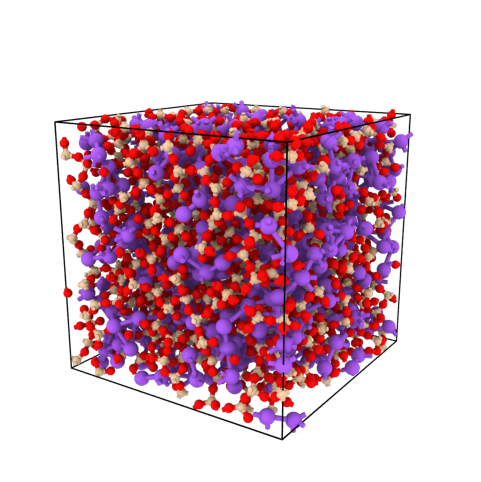

In [1]:
from vitrum.visualization import Pipeline
from vitrum.utility import correct_atom_types
from ase.io import read
import numpy as np
atoms = read("examples/analysis/md.lammpstrj", index=":" , format="lammps-dump-text")
correct_atom_types(atoms, {1: "Na", 2: "O", 3: "Si"})
colors = [np.random.rand(1) for i in range(0, len(atoms[0]))]
pipeline = Pipeline(atoms[0], radii={"Na":1, "Si": 0.6, "O": 0.6}, bonds={("Si", "O"): 2, ("Na", "Na"):4}, bond_width=0.6)
pipeline.render(render_to="image")

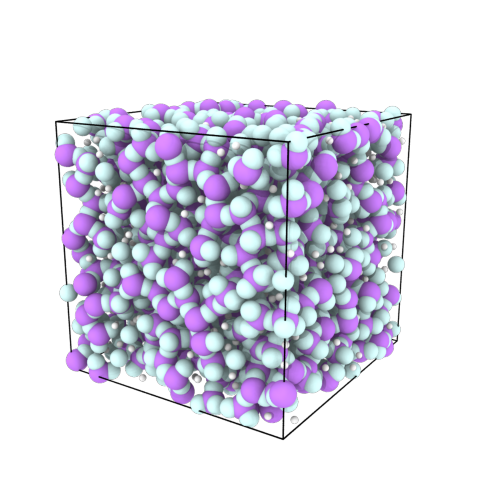

In [2]:
atoms = read("examples/analysis/md.lammpstrj", index=":" , format="lammps-dump-text")
pipeline = Pipeline(atoms[0])
pipeline.render(render_to="image")

In [5]:
atoms[0]

Atoms(symbols='Na600O1700Si700', pbc=True, cell=[34.437680244267156, 34.437680244267156, 34.437680244267156])